### Disclaimer

The following notebook was compiled for the course 'Geostatistics' at Ghent University (lecturer-in-charge: Prof. Dr. Ellen Van De Vijver; teaching assistant: Pablo De Weerdt). It consists of notebook snippets created by Michael Pyrcz. The code and markdown (text) snippets were edited specifically for this course, using the 'Jura data set' (Goovaerts, 1997) as example in the practical classes. Some new code snippets are also included to cover topics which were not found in the Geostastpy package demo books.

This notebook is for educational purposes.<br> 

Guidelines for getting started were adapted from the 'Environmental Soil Sensing' course at Ghent University (lecturer-in-charge: Prof. Dr. Philippe De Smedt).<br> 

The Jura data set was taken from: Goovaerts P., 1997. Geostatistics for Natural Resources Evaluation. Oxford University Press.

**Don't forget to save a copy on your Google drive before starting**

You can also 'mount' your Google Drive in Google colab to directly access your Drive folders (e.g. to access data, previous notebooks etc.)

Do not hesitate to contact us for questions or feel free to ask questions during the practical sessions.

# Geostatistics: Introduction to geostatistical data analysis with Python

In [1]:
# Import required packages for setup
# -------------------------------------------- #

import sys
import os

In [2]:
#  Clone the repository and add it to the path

if 'google.colab' in sys.modules:

    repo_path = '/content/draft_E_I002454_Geostatistics'
    if not os.path.exists(repo_path):
        !git clone https://github.com/SENSE-UGent/E_I002454_Geostatistics.git
    if repo_path not in sys.path:
        sys.path.append(repo_path) #Default location in Google Colab after cloning

else:
    # if you are not using Google Colab, change the path to the location of the repository

    repo_path = r'c:/Users/pdweerdt/Documents/Repos/draft_E_I002454_Geostatistics' # Change this to the location of the repository on your machine
    if repo_path not in sys.path:
        sys.path.append(repo_path) 

# Import the setup function
from Utils.setup import check_and_install_packages

# Read the requirements.txt file

requirements_path = repo_path + '/Utils/requirements.txt'

with open(requirements_path) as f:
    required_packages = f.read().splitlines()

# Check and install packages
check_and_install_packages(required_packages)

#### Load Required libraries

In [3]:
import geostatspy
import geostatspy.GSLIB as GSLIB                              # GSLIB utilities, visualization and wrapper
import geostatspy.geostats as geostats                        # if this raises an error, you might have to check your numba isntallation   
print('GeostatsPy version: ' + str(geostatspy.__version__))   # these notebooks were tested with GeostatsPy version: 0.0.72

GeostatsPy version: 0.0.72


In [4]:
# there was a small bug in the original kb2d_locations code from the geostatspy package
# we have fixed this bug in the Utils.func module

from Utils.func import kb2d_locations_v2

In [5]:
from Utils.func import read_mod_file

We will also need some standard packages. These should have been installed.

In [6]:
from tqdm import tqdm                                         # suppress the status bar
from functools import partialmethod

tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)
                                   
import numpy as np                                            # ndarrays for gridded data
                                       
import pandas as pd                                           # DataFrames for tabular data

import matplotlib.pyplot as plt                               # for plotting

from scipy import stats                                       # summary statistics

plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements

ignore_warnings = True                                        # ignore warnings?
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')

from IPython.utils import io                                  # mute output from simulation

seed = 42                                                     # random number seed

### Optional libraries

These are not required to run the given version of this practical exercise, but might be useful if you want to extend this notebook with more code.

In [7]:
#  import math library
import math

import cmath

In [8]:
from scipy.stats import pearsonr                              # Pearson product moment correlation
from scipy.stats import spearmanr                             # spearman rank correlation    
                                   
import seaborn as sns                                         # advanced plotting

import matplotlib as mpl                                        

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib.colors import ListedColormap 
import matplotlib.ticker as mtick 
import matplotlib.gridspec as gridspec

### Set the Working Directory

Do this to simplify subsequent reads and writes (avoid including the full address each time). 

##### For use in Google Colab

Run the following cell if you automatically want to get the data from the repository and store it on your Google Colab drive

In [9]:
# get the current directory and store it as a variable

cd = os.getcwd()
print('Current Working Directory is ', cd)

Current Working Directory is  c:\Users\pdweerdt\Documents\Repos\draft_E_I002454_Geostatistics\Notebooks


##### For local use

Only run the following cell if you have the data locally stored.

In [10]:
# set the working directory, place an r in front to address special characters
os.chdir(r'c:\Users\pdweerdt\Documents\Repos')

# get the current directory and store it as a variable

cd = os.getcwd()
print('Current Working Directory is ', cd)

Current Working Directory is  c:\Users\pdweerdt\Documents\Repos


### Loading Tabular & Gridded Data

Here's the section to load our data file into a Pandas' DataFrame object.

Let's load and visualize a grid also.

Check the datatype of your gridded data.

In this case it is actually also a .dat file, so we can use the same function to import it. The .grid extension was given to indicate that it is gridded data.

In [11]:
# Here you can adjust the relative Path to the data folder

data_path = cd + '/draft_E_I002454_Geostatistics/Hard_data' 

In [12]:
file_name = '//Cd_9thresh.dat'

df = GSLIB.GSLIB2Dataframe(data_path + file_name) # read the data

df.head()

,X,Y,Cd,Indicator1:,Indicator2:,Indicator3:,Indicator4:,Indicator5:,Indicator6:,Indicator7:,Indicator8:,Indicator9:
0,2.386,3.077,1.740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,2.544,1.972,1.335,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,2.807,3.347,1.610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,4.308,1.933,2.150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4.383,1.081,1.565,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


In [13]:
grid_file_name = '//rocktype.grid'

# load the data

df_grid = GSLIB.GSLIB2Dataframe(data_path + grid_file_name)

df_grid.head()

,x,y,rocktype
0,0.3,1.65,3.0
1,0.3,1.70,3.0
2,0.3,1.75,3.0
3,0.3,1.80,2.0
4,0.3,2.15,1.0


### Define feature of interest

In [14]:
feature = 'Cd'
unit = 'ppm'
dist_unit = 'km'

In [15]:
#  define a colormap

cmap = plt.cm.inferno                                         # color map inferno

cmap_rainb = plt.cm.turbo # similar to what is shown on the slides

## Calculate some statistics

In P1 we calculated some statistics

In [16]:
min_feat = round((df[feature].values).min(), 2)                    # calculate the minimum
max_feat = round((df[feature].values).max(), 2)                    # calculate the maximum
mean_feat = round((df[feature].values).mean(), 2)                  # calculate the mean
stdev_feat = round((df[feature].values).std(), 2)                  # calculate the standard deviation
n_feat = df[feature].values.size                                   # calculate the number of data

print('The minimum is ' + str(min_feat) + ' ' + str(unit) + '.')   # print univariate statistics
print('The maximum is ' + str(max_feat) + ' ' + str(unit) + '.')
print('The mean is ' + str(mean_feat) + ' ' + str(unit) + '.')
print('The standard deviation is ' + str(stdev_feat) + ' ' + str(unit) + '.')
print('The number of data is ' + str(n_feat) + '.')


The minimum is 0.14 ppm.
The maximum is 5.13 ppm.
The mean is 1.31 ppm.
The standard deviation is 0.91 ppm.
The number of data is 259.


# Ordinary Kriging for prediction Maps

Remember that we use both our prediction data and a variogram model as inputs into the OK prediction algorithm. We already loaded our prediction data and grid. Let's have a look at the grid and also define our search neigbourhood and the variogram model.


## Grid

We can initialise a new column into our grid dataframe for the OK prediction.

In [17]:
df_grid[feature + 'OK'] = -99999 # assign a dummy value to the new feature

In [18]:
xmin = 0; xmax = np.ceil(df.X.max()) # range of x values
ymin = 0; ymax = np.ceil(df.Y.max()) # range of y values

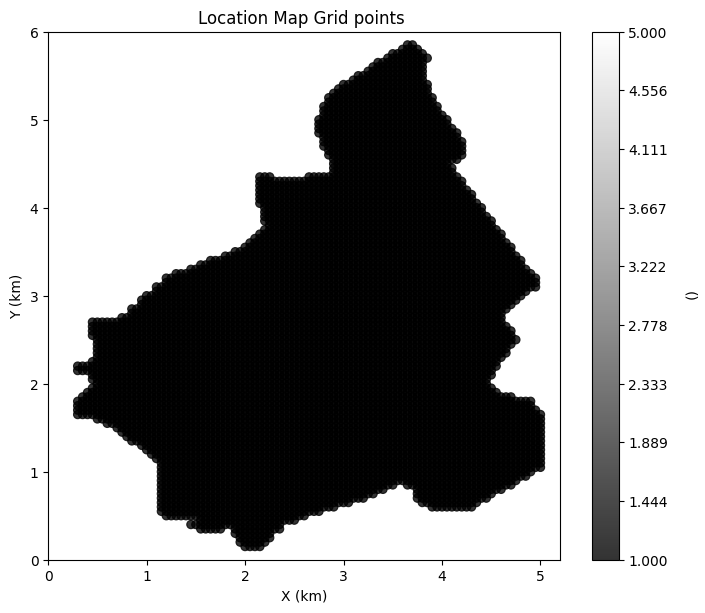

In [19]:
GSLIB.locmap_st(df_grid,'x', 'y', feature + 'OK',
                0, 5.2, ymin, ymax, 
                1, 5, # set the value range for the color map
                (
                    'Location Map Grid points ' 
               #   + str(grid_feature)
                 ), 
                 'X (km)', 'Y (km)',
             (
               #   str(grid_feature) + ' (' + str(unit) + ')'
                 ), 'gray')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.1, hspace=0.2)

We can hardly differentiate the individual grid points but they are surely there! Also ignore the colobar in this case as we focus on the grid locations.

#### Indicator Kriging for continuous data

To demonstrate indicator kriging variogram models are given, rather than calculate experimental variograms and then model them.

Let's first set up the basic indicator kriging parameters:

Now, let's specify the thresholds

In [20]:
#  often the thresholds are chosen corresponding to the 9 deciles of the data
#  
#  the probabilities corresponding to the deciles 
probabilities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] 

#  the deciles are calculated using the numpy percentile function, 
# this function assumes percentages instead of fractions, so we multiply the probabilities by 100
deciles = np.percentile(df[feature].values, [p * 100 for p in probabilities]) # 10 deciles

print('The deciles are: ' + str(deciles))

ncut = 9                                                     # number of thresholds

thresholds = deciles.copy() # copy the deciles to the thresholds

The deciles are: [0.395  0.573  0.7338 0.886  1.07   1.38   1.573  1.879  2.2926]


In [21]:
# read .mod file

# read all mod files corresonding to the 9 thresholds
# use a for loop to read the mod files and store them in a list
#  the mod files are stored in the data_path folder, with the name 'Cd_9thresh_0.mod', 'Cd_9thresh_1.mod', etc.
varios = []

for i in range(0, ncut):

    mod_file_name = '//variogramthr' + str(i+1) + '.mod' # name of the .mod file
    print('Reading ' + data_path + mod_file_name)
    var = read_mod_file(data_path + '//varmods_IK' + mod_file_name) # read the data
    # append the variogram to the list
    varios.append(var)

varios

Reading c:\Users\pdweerdt\Documents\Repos/draft_E_I002454_Geostatistics/Hard_data//variogramthr1.mod
Reading c:\Users\pdweerdt\Documents\Repos/draft_E_I002454_Geostatistics/Hard_data//variogramthr2.mod
Reading c:\Users\pdweerdt\Documents\Repos/draft_E_I002454_Geostatistics/Hard_data//variogramthr3.mod
Reading c:\Users\pdweerdt\Documents\Repos/draft_E_I002454_Geostatistics/Hard_data//variogramthr4.mod
Reading c:\Users\pdweerdt\Documents\Repos/draft_E_I002454_Geostatistics/Hard_data//variogramthr5.mod
Reading c:\Users\pdweerdt\Documents\Repos/draft_E_I002454_Geostatistics/Hard_data//variogramthr6.mod
Reading c:\Users\pdweerdt\Documents\Repos/draft_E_I002454_Geostatistics/Hard_data//variogramthr7.mod
Reading c:\Users\pdweerdt\Documents\Repos/draft_E_I002454_Geostatistics/Hard_data//variogramthr8.mod
Reading c:\Users\pdweerdt\Documents\Repos/draft_E_I002454_Geostatistics/Hard_data//variogramthr9.mod


[{'nug': 0.04,
  'nst': 1,
  'cc1': 0.05,
  'it1': 1,
  'azi1': 0.0,
  'hmaj1': 1.4,
  'hmin1': 1.4,
  'cc2': 0,
  'it2': 1,
  'azi2': 0,
  'hmaj2': 0,
  'hmin2': 0},
 {'nug': 0.08,
  'nst': 1,
  'cc1': 0.085,
  'it1': 1,
  'azi1': 0.0,
  'hmaj1': 1.4,
  'hmin1': 1.4,
  'cc2': 0,
  'it2': 1,
  'azi2': 0,
  'hmaj2': 0,
  'hmin2': 0},
 {'nug': 0.09,
  'nst': 1,
  'cc1': 0.13,
  'it1': 1,
  'azi1': 0.0,
  'hmaj1': 1.3,
  'hmin1': 1.3,
  'cc2': 0,
  'it2': 1,
  'azi2': 0,
  'hmaj2': 0,
  'hmin2': 0},
 {'nug': 0.15,
  'nst': 1,
  'cc1': 0.11,
  'it1': 1,
  'azi1': 0.0,
  'hmaj1': 1.7,
  'hmin1': 1.7,
  'cc2': 0,
  'it2': 1,
  'azi2': 0,
  'hmaj2': 0,
  'hmin2': 0},
 {'nug': 0.17,
  'nst': 1,
  'cc1': 0.1,
  'it1': 1,
  'azi1': 0.0,
  'hmaj1': 1.8,
  'hmin1': 1.8,
  'cc2': 0,
  'it2': 1,
  'azi2': 0,
  'hmaj2': 0,
  'hmin2': 0},
 {'nug': 0.14,
  'nst': 1,
  'cc1': 0.11,
  'it1': 1,
  'azi1': 0.0,
  'hmaj1': 1.1,
  'hmin1': 1.1,
  'cc2': 0,
  'it2': 1,
  'azi2': 0,
  'hmaj2': 0,
  'hmin2': 0}

In [ ]:
# ncut2 = 2                                                      # number of facies
# thresh2 = [0,1]                                                # the facies categories
# gcdf2 = [0.4,0.6]                                              # the global proportions of the categories
# vrange2 = 500.0                                                # variogram range
# varios2 = []                                                   # the variogram list
# varios2.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=vrange,hmin1=vrange)) # shale ind. variogram
# varios2.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=vrange,hmin1=vrange)) # sand ind. variogram

# varios2

We are ready to run the indicator kriging with the 2 categories (sand and shale) and calculate the probability of sand and shale at all locations and plot the results.

In [ ]:
help(geostats.ik2d)

In [22]:
nxdis = 1; nydis = 1                                          # block kriging discretizations, 1 for point kriging
ndmin = 2; ndmax = 15                                         # minimum and maximum data for kriging 
radius = 1                                                  # maximum search distance
ktype = 1                                                     # kriging type, 0 - simple, 1 - ordinary
ivtype = 1                                                    # variable type, 0 - categorical, 1 - continuous
tmin = -999; tmax = 9999

In [23]:
# Configure grid parameters
# Determine grid dimensions from the grid data
nx = len(df_grid['x'].unique())
ny = len(df_grid['y'].unique())
nz = 1  # 2D grid, so nz=1

# Get grid origin and cell size
xmn = df_grid['x'].min()
ymn = df_grid['y'].min()
zmn = 0.0  # 2D grid
xsiz = 0.05
ysiz = 0.05
zsiz = 0.05  # Not used in 2D

# Block discretization (for point kriging, set to 1)
nxdis, nydis, nzdis = 1, 1, 1

print(f"Grid dimensions: {nx} x {ny}")
print(f"Grid origin: ({xmn}, {ymn})")
print(f"Grid cell size: {xsiz} x {ysiz}")

Grid dimensions: 95 x 115
Grid origin: (0.3, 0.15)
Grid cell size: 0.05 x 0.05


In [24]:
import numpy as np
import scipy.spatial as sp  # for fast nearest neighbor search
from geostatspy.geostats import setup_rotmat, cova2, ksol_numpy
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import xml.etree.ElementTree as ET

In [30]:
def ik2d_v2(df,xcol,ycol,vcol,ivtype,koption,ncut,thresh,gcdf,trend,tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius,ktype,vario):
          
    """A 2D version of GSLIB's IK3D Indicator Kriging program (Deutsch and Journel, 1998) converted from the
    original Fortran to Python by Michael Pyrcz, the University of Texas at
    Austin (March, 2019).
    :param df: pandas DataFrame with the spatial data
    :param xcol: name of the x coordinate column
    :param ycol: name of the y coordinate column
    :param vcol: name of the property column (cateogorical or continuous - note continuous is untested)
    :param ivtype: variable type, 0 - categorical, 1 - continuous
    :param koption: kriging option, 0 - estimation, 1 - cross validation (under construction)
    :param ncut: number of categories or continuous thresholds
    :param thresh: an ndarray with the category labels or continuous thresholds
    :param gcdf: global CDF, not used if trend is present
    :param trend: an ndarray [ny,ny,ncut] with the local trend proportions or cumulative CDF values
    :param tmin: property trimming limit
    :param tmax: property trimming limit
    :param nx: definition of the grid system (x axis)
    :param xmn: definition of the grid system (x axis)
    :param xsiz: definition of the grid system (x axis)
    :param ny: definition of the grid system (y axis)
    :param ymn: definition of the grid system (y axis)
    :param ysiz: definition of the grid system (y axis)
    :param nxdis: number of discretization points for a block
    :param nydis: number of discretization points for a block
    :param ndmin: minimum number of data points to use for kriging a block
    :param ndmax: maximum number of data points to use for kriging a block
    :param radius: maximum isotropic search radius
    :param ktype: kriging type, 0 - simple kriging and 1 - ordinary kriging
    :param vario: list with all of the indicator variograms (sill of 1.0) in consistent order with above parameters
    :return:
    """
        
# Find the needed paramters:
    PMX = 9999.9
    UNEST = -999
    MAXSAM = ndmax + 1
    MAXEQ = MAXSAM + 1
    mik = 0  # full indicator kriging
    use_trend = False
    if trend.shape[0] == nx and trend.shape[1] == ny and trend.shape[2] == ncut: use_trend = True
    
# load the variogram
    MAXNST = 2
    nst = np.zeros(ncut,dtype=int); c0 = np.zeros(ncut); cc = np.zeros((MAXNST,ncut)) 
    aa = np.zeros((MAXNST,ncut),dtype=int); it = np.zeros((MAXNST,ncut),dtype=int) 
    ang = np.zeros((MAXNST,ncut)); 
    # fill anis with 1.0 for isotropic variograms
    anis = np.ones((MAXNST,ncut))
    print(anis)

    for icut in range(0,ncut):
        nst[icut] = int(vario[icut]['nst'])
        c0[icut] = vario[icut]['nug']; cc[0,icut] = vario[icut]['cc1']; it[0,icut] = vario[icut]['it1']; 
        ang[0,icut] = vario[icut]['azi1']; 
        aa[0,icut] = vario[icut]['hmaj1']; anis[0,icut] = vario[icut]['hmin1']/vario[icut]['hmaj1'];
        if nst[icut] == 2:
            print('two structures detected')
            cc[1,icut] = vario[icut]['cc2']; it[1,icut] = vario[icut]['it2']; ang[1,icut] = vario[icut]['azi2']; 
            aa[1,icut] = vario[icut]['hmaj2']; anis[1,icut] = vario[icut]['hmin2']/vario[icut]['hmaj2'];

# Load the data
    df_extract = df.loc[(df[vcol] >= tmin) & (df[vcol] <= tmax)]    # trim values outside tmin and tmax
    MAXDAT = len(df_extract)
    MAXCUT = ncut
    MAXNST = 2
    MAXROT = MAXNST*MAXCUT+ 1
    ikout = np.zeros((nx,ny,ncut))
    maxcov = np.zeros(ncut)
            
    # Allocate the needed memory:   
    xa = np.zeros(MAXSAM)
    ya = np.zeros(MAXSAM)
    vra = np.zeros(MAXSAM)
    dist = np.zeros(MAXSAM)
    nums = np.zeros(MAXSAM)
    r = np.zeros(MAXEQ)
    rr = np.zeros(MAXEQ)
    s = np.zeros(MAXEQ)
    a = np.zeros(MAXEQ*MAXEQ)
    ikmap = np.zeros((nx,ny,ncut))
    vr = np.zeros((MAXDAT,MAXCUT+1))
    
    nviol = np.zeros(MAXCUT)
    aviol = np.zeros(MAXCUT)
    xviol = np.zeros(MAXCUT)
    
    ccdf = np.zeros(ncut)
    ccdfo = np.zeros(ncut)
    ikout = np.zeros((ny,nx,ncut))
    
    x = df_extract[xcol].values
    y = df_extract[ycol].values
    v = df_extract[vcol].values
    
# The indicator data are constructed knowing the thresholds and the
# data value.
    
    if ivtype == 0:
        for icut in range(0,ncut): 
            vr[:,icut] = np.where((v <= thresh[icut] + 0.5) & (v > thresh[icut] - 0.5), '1', '0')
    else:
        for icut in range(0,ncut): 
            vr[:,icut] = np.where(v <= thresh[icut], '1', '0')
    vr[:,ncut] = v

# Make a KDTree for fast search of nearest neighbours   
    dp = list((y[i], x[i]) for i in range(0,MAXDAT))
    data_locs = np.column_stack((y,x))
    tree = sp.cKDTree(data_locs, leafsize=16, compact_nodes=True, copy_data=False, balanced_tree=True)
    
# Summary statistics of the input data
    
    avg = vr[:,ncut].mean()
    stdev = vr[:,ncut].std()
    ss = stdev**2.0
    vrmin = vr[:,ncut].min()
    vrmax = vr[:,ncut].max()
    print('Data for ik2d: Variable column ' + str(vcol))
    print('  Number   = ' + str(MAXDAT))
    ndh = MAXDAT
    
    actloc = np.zeros(MAXDAT, dtype = int)
    for i in range(1,MAXDAT):
        actloc[i] = i
    
# Set up the rotation/anisotropy matrices that are needed for the
# variogram and search:

    print('Setting up rotation matrices for variogram and search')
    radsqd = radius * radius
    rotmat = []
    for ic in range(0,ncut):  
        rotmat_temp, maxcov[ic] = setup_rotmat(c0[ic],int(nst[ic]),it[:,ic],cc[:,ic],ang[:,ic],9999.9)
        rotmat.append(rotmat_temp)    
# Initialize accumulators:  # not setup yet
    nk = 0
    xk = 0.0
    vk = 0.0
    for icut in range (0,ncut):
        nviol[icut] =  0
        aviol[icut] =  0.0
        xviol[icut] = -1.0
    nxy   = nx*ny
    print('Working on the kriging')

# Report on progress from time to time:
    if koption == 0: 
        nxy   = nx*ny
        nloop = nxy
        irepo = max(1,min((nxy/10),10000))
    else:
        nloop = 10000000
        irepo = max(1,min((nd/10),10000))
    ddh = 0.0
    
# MAIN LOOP OVER ALL THE BLOCKS IN THE GRID:
    for index in range(0,nloop):
      
        if (int(index/irepo)*irepo) == index: print('   currently on estimate ' + str(index))
    
        if koption == 0:
            iy   = int((index)/nx) 
            ix   = index - (iy)*nx
            xloc = xmn + (ix)*xsiz
            yloc = ymn + (iy)*ysiz
        else:
            ddh = 0.0
            # TODO: pass the cross validation value

# Find the nearest samples within each octant: First initialize the counter arrays:
        na = -1   # accounting for 0 as first index
        dist.fill(1.0e+20)
        nums.fill(-1)
        current_node = (yloc,xloc)
        dist, close = tree.query(current_node,ndmax) # use kd tree for fast nearest data search
        # remove any data outside search radius
        close = close[dist<radius]
        dist = dist[dist<radius] 
        nclose = len(dist) 

# Is there enough samples?

        if nclose < ndmin:   # accounting for min index of 0
            for i in range(0,ncut):
                ccdfo[i] = UNEST
            print('UNEST at ' + str(ix) + ',' + str(iy))
        else:         

# Loop over all the thresholds/categories:
            for ic in range(0,ncut):
                krig = True
                if mik == 1 and ic >= 1: krig = False

# Identify the close data (there may be a different number of data at
# each threshold because of constraint intervals); however, if
# there are no constraint intervals then this step can be avoided.
                nca = -1
                for ia in range(0,nclose):
                    j  = int(close[ia]+0.5)
                    ii = actloc[j]
                    accept = True
                    if koption != 0 and (abs(x[j]-xloc) + abs(y[j]-yloc)).lt.EPSLON: accept = False
                    if accept:
                        nca = nca + 1
                        vra[nca] = vr[ii,ic]
                        xa[nca]  = x[j]
                        ya[nca]  = y[j]

# If there are no samples at this threshold then use the global cdf:
                if nca == -1:
                    if use_trend:
                        ccdf[ic] = trend[ny-iy-1,ix,ic]
                    else:
                        ccdf[ic] = gcdf[ic]
                else:
            
# Now, only load the variogram, build the matrix,... if kriging:
                    neq = nclose + ktype
                    na = nclose

# Set up kriging matrices:
                    iin=-1 # accounting for first index of 0
                    for j in range(0,na):
# Establish Left Hand Side Covariance Matrix:
                        for i in range(0,na):  # was j - want full matrix                    
                            iin = iin + 1
                            a[iin] = cova2(xa[i],ya[i],xa[j],ya[j],nst[ic],c0[ic],PMX,cc[:,ic],aa[:,ic],it[:,ic],ang[:,ic],anis[:,ic],rotmat[ic],maxcov[ic]) 
                        if ktype == 1:
                            iin = iin + 1
                            a[iin] = maxcov[ic]            
                        r[j] = cova2(xloc,yloc,xa[j],ya[j],nst[ic],c0[ic],PMX,cc[:,ic],aa[:,ic],it[:,ic],ang[:,ic],anis[:,ic],rotmat[ic],maxcov[ic]) 
    
# Set the unbiasedness constraint:
                    if ktype == 1:
                        for i in range(0,na):
                            iin = iin + 1
                            a[iin] = maxcov[ic]
                        iin      = iin + 1
                        a[iin]   = 0.0
                        r[neq-1]  = maxcov[ic]
                        rr[neq-1] = r[neq]
# Solve the system:
                    if neq == 1:
                        ising = 0.0
                        s[0]  = r[0] / a[0]
                    else:
                        s = ksol_numpy(neq,a,r)

# Finished kriging (if it was necessary):

# Compute Kriged estimate of cumulative probability:
                    sumwts   = 0.0
                    ccdf[ic] = 0.0
                    for i in range(0,nclose):
                        ccdf[ic] = ccdf[ic] + vra[i]*s[i]
                        sumwts   = sumwts   + s[i]
                    if ktype == 0: 
                        if use_trend == True:
                            ccdf[ic] = ccdf[ic] + (1.0-sumwts)*trend[ny-iy-1,ix,ic]
                        else:
                            ccdf[ic] = ccdf[ic] + (1.0-sumwts)*gcdf[ic]

# Keep looping until all the thresholds are estimated:
 
# Correct and write the distribution to the output file:
            nk = nk + 1
            ccdfo = ordrel(ivtype,ncut,ccdf)
        
# Write the IK CCDF for this grid node:
            if koption == 0:
                print("location " + str(ny-iy-1) + ',' + str(ix) + '  ' + str(ccdfo))
                ikout[ny-iy-1,ix,:] = ccdfo
            else:
                 print('TBD')
    return ikout

In [27]:
# import ordrel from geostats 
from geostatspy.geostats import ordrel

In [28]:
print(ncut)
print(thresholds)
print(probabilities)

9
[0.395  0.573  0.7338 0.886  1.07   1.38   1.573  1.879  2.2926]
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


In [26]:
def cova2(x1, y1, x2, y2, nst, c0, pmx, cc, aa, it, ang, anis, rotmat, maxcov):
    """Calculate the covariance associated with a variogram model specified by a
    nugget effect and nested variogram structures.
    :param x1: x coordinate of first point
    :param y1: y coordinate of first point
    :param x2: x coordinate of second point
    :param y2: y coordinate of second point
    :param nst: number of nested structures (maximum of 4)
    :param c0: isotropic nugget constant (TODO: not used)
    :param pmx: TODO
    :param cc: multiplicative factor of each nested structure
    :param aa: parameter `a` of each nested structure
    :param it: TODO
    :param ang: TODO: not used
    :param anis: TODO
    :param rotmat: rotation matrices
    :param maxcov: TODO
    :return: TODO
    """
    EPSLON = 0.000001

    # Check for very small distance
    dx = x2 - x1
    dy = y2 - y1

    if (dx * dx + dy * dy) < EPSLON:
        cova2_ = maxcov
        return cova2_

    # Non-zero distance, loop over all the structures
    cova2_ = 0.0
    for js in range(0, nst):
        # Compute the appropriate structural distance
        dx1 = dx * rotmat[0, js] + dy * rotmat[1, js]
        dy1 = (dx * rotmat[2, js] + dy * rotmat[3, js]) / anis[js]
        h = math.sqrt(max((dx1 * dx1 + dy1 * dy1), 0.0))
        if it[js] == 1:
            # Spherical model
            hr = h / aa[js]
            if hr < 1.0:
                cova2_ = cova2_ + cc[js] * (1.0 - hr * (1.5 - 0.5 * hr * hr))
        elif it[js] == 2:
            # Exponential model
            cova2_ = cova2_ + cc[js] * np.exp(-3.0 * h / aa[js])
        elif it[js] == 3:
            # Gaussian model
            hh = -3.0 * (h * h) / (aa[js] * aa[js])
            cova2_ = cova2_ + cc[js] * np.exp(hh)
        elif it[js] == 4:
            # Power model
            cov1 = pmx - cc[js] * (h ** aa[js])
            cova2_ = cova2_ + cov1
    return cova2_

In [31]:
# %%capture --no-display   

no_trend = np.zeros((1,1))                                    # null ndarray not of correct size so ik2d will not trend
ikmap = ik2d_v2(df,'X','Y',feature,ivtype,0,ncut,thresholds,probabilities,no_trend,tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,
                # nxdis,nydis,
                ndmin,ndmax,radius,ktype,varios)

[[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Data for ik2d: Variable column Cd
  Number   = 259
Setting up rotation matrices for variogram and search
Working on the kriging
   currently on estimate 0
UNEST at 0,0
UNEST at 1,0
UNEST at 2,0
UNEST at 3,0
UNEST at 4,0
UNEST at 5,0
UNEST at 6,0
UNEST at 7,0
location 114,8  [0.         0.         0.         0.         0.52075896 1.
 1.         1.         1.        ]
location 114,9  [0.         0.         0.         0.         0.52683589 1.
 1.         1.         1.        ]
location 114,10  [0.         0.         0.         0.         0.53236767 1.
 1.         1.         1.        ]
location 114,11  [0.         0.         0.         0.         0.53731082 1.
 1.         1.         1.        ]
location 114,12  [0.         0.         0.         0.         0.54161207 1.
 1.         1.         1.        ]
location 114,13  [0.         0.         0.         0.         0.54520748 1.
 1.         1.         1.        ]
location 114,14 

In [ ]:
def locpix_colormaps_st(array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel_loc,vlabel,cmap_loc,cmap):
    xx, yy = np.meshgrid(
        np.arange(xmin, xmax, step), np.arange(ymax, ymin, -1 * step)
    )
    cs = plt.imshow(array,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = vmin, vmax = vmax,cmap = cmap)
    plt.scatter(df[xcol],df[ycol],s=None,c=df[vcol],marker=None,cmap=cmap_loc,vmin=vmin,vmax=vmax,alpha=0.8,linewidths=0.8,
        edgecolors="black",)
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel); plt.xlim(xmin, xmax); plt.ylim(ymin, ymax)
    cbar_loc = plt.colorbar(orientation="vertical",pad=0.08,ticks=[0, 1],
            format=mticker.FixedFormatter(['Shale','Sand'])); cbar_loc.set_label(vlabel_loc, rotation=270,labelpad=20)
    cbar = plt.colorbar(cs,orientation="vertical",pad=0.05); cbar.set_label(vlabel, rotation=270,labelpad=20)
    return cs

In [ ]:
# import locpix_colormaps_st from geostatspy.GSLIB
from geostats import locpix_colormaps_st

In [ ]:
import matplotlib.ticker as mticker                           # custom colorpar ticks

In [ ]:
ikmap

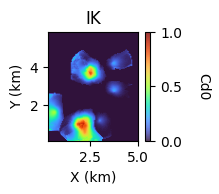

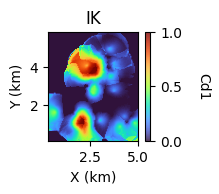

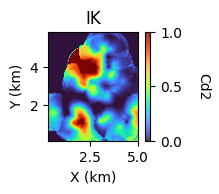

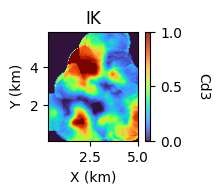

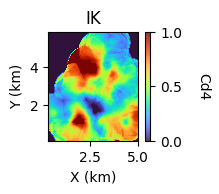

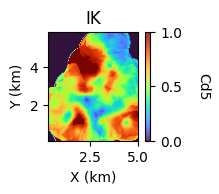

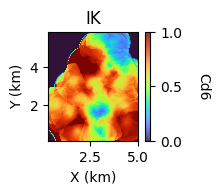

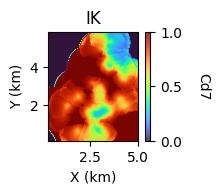

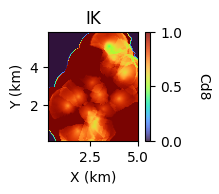

<Figure size 640x480 with 0 Axes>

In [41]:
for i in range (0,ncut):
    plt.subplot(3,3,i+1) # 3 rows, 3 columns, i+1 is the index of the subplot
    GSLIB.pixelplt_st(ikmap[:,:,i],
                  df_grid['x'].min(),df_grid['x'].max(),df_grid['y'].min(),df_grid['y'].max(), #we have to use the actual min and max values
                  0.05,0,1,'IK','X (km)','Y (km)',
                  (str(feature) + str(i)), cmap_rainb); plt.show()

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.1); 
plt.show()

In [ ]:
plt.subplot(121) 
locpix_colormaps_st(ikmap[:,:,0],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,df,'X','Y',feature,
                'Well Data and Indicator Kriged Probability Shale',
                'X(m)','Y(m)','Facies','Probability Shale Facies',cmap,cmap)
plt.subplot(122) 
locpix_colormaps_st(ikmap[:,:,1],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,df,'X','Y',feature,
                'Well Data and Indicator Kriged Probability Sand',
                'X(m)','Y(m)','Facies','Probability Sand Facies',cmap,cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.8, wspace=0.2, hspace=0.2); plt.show()

# Post processing

In [43]:
# import the beyond function
from geostatspy.geostats import beyond

In [44]:
help(beyond)

Help on function beyond in module geostatspy.geostats:

beyond(ivtype, nccut, ccut, ccdf, ncut, cut, cdf, zmin, zmax, ltail, ltpar, middle, mpar, utail, utpar, zval, cdfval)
    GSLIB's BEYOND subroutine (Deutsch and Journel, 1998) converted from the
    original Fortran to Python by Michael Pyrcz, the University of Texas at
    Austin (March, 2019).
    Note this was simplified to 2D only.



In [45]:
np.random.rand()

0.5889080768441074

In [50]:
gcut = len(df) 
gcut

ng = 0 # no tabulated values 

In [64]:
zmin=0.0
zmax=np.nan
ltail=2
ltpar=2.5
middle=1    # Straight Linear Interpolation:
mpar=0
utail=4 #1=power, #2 power with par, 3= lin, 4=hyperbo
utpar=1.5 # omega

In [58]:
def locate(xx,iis,iie,x):
    """Return value `j` such that `x` is between `xx[j]` and `xx[j+1]`, where
    `xx` is an array of length `n`, and `x` is a given value. `xx` must be
    monotonic, either increasing or decreasing (GSLIB version).
    :param xx: array
    :param iis: start point
    :param iie: end point
    :param x: given value
    :return: TODO
    """
    
    n = len(xx)
# Initialize lower and upper methods:
    if iis <= 0: 
        iis = 0
    if iie >= n:
        iie = n-1
    jl = iis-1
    ju = iie
    if xx[n-1] <= x:
        j = iie
        return j
# If we are not done then compute a midpoint:
    while (ju-jl) > 1: 
        jm = int((ju+jl)/2)
# Replace the lower or upper limit with the midpoint:
        if (xx[iie] > xx[iis]) == (x > xx[jm]):
            jl = jm
        else:
            ju = jm
# Return with the array index:
    j = jl
    return j

In [61]:
def powint(xlow,xhigh,ylow,yhigh,xval,power):
    """Power-based interpolator 
    :param xlow: x lower interval
    :param xhigh: x upper interval
    :param ylow: y lower interval
    :param yhigh: y upper interval
    :param xval: value on x
    :param power: power for interpolation
    :return: TODO
    """    
    EPSLON=1.0e-20
    if (xhigh-xlow) < EPSLON:
        powint = (yhigh+ylow)/2.0
    else:
        powint = ylow + (yhigh-ylow)*(((xval-xlow)/(xhigh-xlow))**power)
    return powint

In [ ]:
def beyond2(ivtype,nccut,ccut,ccdf,ncut,cut,cdf,zmin,zmax,ltail,ltpar,middle,mpar,utail,utpar,zval,cdfval):
#-----------------------------------------------------------------------
#
#                     Go Beyond a Discrete CDF
#                     ************************
#
# This subroutine is a general purpose subroutine to interpolate within
# and extrapolate beyond discrete points on a conditional CDF.  If the
# Z value "zval" is specified then the corresponding CDF value "cdfval"
# will be computed, if the CDF value "cdfval" is specified the
# corresponding Z value "zval" will be computed.
#
#
#
# INPUT/OUTPUT VARIABLES:
#
#   ivtype           variable type (1=continuous, 0=categorical)
#   nccut            number of cutoffs defining the conditional CDF
#   ccut()           real array of the nccut cutoffs
#   ccdf()           real array of the conditional cdf values
#   ncut             number of cutoffs defining the global CDF
#   cut()            real array of the ncut cutoffs
#   cdf()            real array of the global cdf values
#
#   zmin,zmax        minimum and maximum allowable data values
#   ltail            option to handle values in lower tail
#   ltpar            parameter required for option ltail
#   middle           option to handle values in the middle
#   mpar             parameter required for option middle
#   utail            option to handle values in upper tail
#   utpar            parameter required for option utail
#
#   zval             interesting cutoff (if -1 then it is calculated)
#   cdfval           interesting CDF (if -1 then it is calculated)
#
#
#-----------------------------------------------------------------------
    EPSLON = 1.0e-20; UNEST=-1.0

# Check for both "zval" and "cdfval" defined or undefined:
    ierr  = 1; 
    if zval > UNEST and cdfval > UNEST: 
        return -1
    if zval <= UNEST and cdfval <= UNEST: 
        return - 1
    
# Handle the case of a categorical variable:
    if ivtype == 0:
        cum = 0
        for i in range(0,nccut):
            cum = cum + ccdf[i]
            if cdfval <= cum:
                zval = ccut[i]
                return zval
        return zval
    
# Figure out what part of distribution: ipart = 0 - lower tail
#                                       ipart = 1 - middle
#                                       ipart = 2 - upper tail
    ierr  = 0
    ipart = 1
    if zval > UNEST:
        if zval <= ccut[0]:       
            ipart = 0
        if zval >= ccut[nccut-1]:
            ipart = 2
    else:
        if cdfval <= ccdf[0][0]:
            ipart = 0
        if cdfval >= ccdf[nccut-1]:
            ipart = 2
      
# ARE WE IN THE LOWER TAIL?

    if ipart == 0: 
        if ltail ==1:
# Straight Linear Interpolation:
            powr = 1.0
            if zval > UNEST:
                cdfval = powint(zmin,ccut[0],0.0,ccdf[0],zval,powr)
            else:
                zval = powint(0.0,ccdf[0],zmin,ccut[0],cdfval,powr)
        elif ltail == 2:

# Power Model interpolation to lower limit "zmin"?
                if zval > UNEST: 
                    cdfval = powint(zmin,ccut[0],0.0,ccdf[0],zval,ltpar)
                else:
                    powr = 1.0 / ltpar
                    zval = powint(0.0,ccdf[0],zmin,ccut[0],cdfval,powr)
                
# Linear interpolation between the rescaled global cdf?
        elif ltail == 3:
            if zval > UNEST:
# Computing the cdf value. Locate the point and the class bound:
                idat = locate(cut,1,ncut,zval)
                iupp = locate(cut,ncut,1,ncut,ccut[0])

# Straight linear interpolation if no data; otherwise, linear:
                if idat <= -1 or idat >= ncut -1 or iupp <= -1 or iupp >= ncut-1: # modfity for 0 index
                    cdfval = powint(zmin,cut[0],0.0,cdf[0],zval,1.)
                else:
                    temp = powint(cut[idat],cut[idat+1],cdf[idat],cdf[idat+1],zval,1.)
                    cdfval = temp*ccdf[0]/cdf[iupp]
            else:

# Computing Z value: Are there any data out in the tail?

                iupp = locate(cut,ncut,1,ncut,ccut[0])

# Straight linear interpolation if no data; otherwise, local linear
# interpolation:
                if iupp <= 0 or iupp >= ncut:
                    zval = powint(0.0,cdf[0],zmin,cut[0],cdfval,1.)
                else:
                    temp = cdfval*cdf[iupp]/ccdf[1]
                    idat = locate(cdf,ncut,1,ncut,temp)
                    if idat <= -1 or idat >= ncut-1:  # adjusted for 0 origin
                        zval = powint(0.0,cdf[0],zmin,cut[0],cdfval,1.)
                    else:
                        zval = powint(cdf[idat],cdf[idat+1],cut[dat],cut[idat+1],temp,1.)
        else:

# Error situation - unacceptable option:
           ierr = 2
           return -1
            
# FINISHED THE LOWER TAIL,  ARE WE IN THE MIDDLE?
    if ipart == 1:

# Establish the lower and upper limits:
        if zval > UNEST: 
            cclow = locate(ccut,1,nccut,zval)
            cchigh = cclow + 1
        else:
            cclow = locate(ccdf,1,nccut,cdfval)
            cchigh = cclow + 1
        if middle == 1:

# Straight Linear Interpolation:
            powr = 1.0
            if zval > UNEST:
                cdfval = powint(ccut[cclow],ccut[cchigh],ccdf[cclow],ccdf[cchigh],zval,powr)
            else:
                zval = powint(ccdf[cclow],ccdf[cchigh],ccut[cclow],ccut[cchigh],cdfval,powr)
                  
# Power interpolation between class bounds?
        elif middle == 2:
                if zval > UNEST:
                    cdfval = powint(ccut[cclow],ccut[cchigh],ccdf[cclow],ccdf[cchigh],zval,mpar)
                else:
                    powr = 1.0 / mpar
                    zval = powint(ccdf[cclow],ccdf[cchigh],ccut[cclow],ccut[cchigh],cdfval,powr)
                  
# Linear interpolation between the rescaled global cdf?
        elif middle == 3:
            ilow = locate(cut,ncut,1,ncut,ccut[cclow])
            iupp = locate(cut,ncut,1,ncut,ccut[cchigh])
            if cut[ilow] < ccut[cclow]:  
                ilow = ilow + 1
            if cut[iupp]  > ccut[cchigh]:  
                iupp = iupp - 1
            if zval > UNEST:
                idat = locate(cut,1,ncut,zval)

# Straight linear interpolation if no data; otherwise, local linear
# interpolation:
                if idat <= -1 or idat >= ncut-1 or ilow <= -1 or ilow >= ncut-1 or iupp <= -1 or iupp >= ncut-1 or iupp <= ilow:
                    cdfval=powint(ccut[cclow],ccut[cchigh],ccdf[cclow],ccdf[cchigh],zval,1.)
                else:
                    temp = powint(cut[idat],cut[idat+1],cdf[idat],cdf[idat+1],zval,1.)
                    cdfval=powint(cdf[ilow],cdf[iupp],ccdf[cclow],ccdf[cchigh],temp,1.)
            else:

# Straight linear interpolation if no data; otherwise, local linear
# interpolation:
                if ilow <= -1 or ilow >= ncut-1 or iup <= -1 or iupp >= ncut-1 or iupp < ilow:
                    zval=powint(ccdf[cclow],ccdf[cchigh],ccut[cclow],ccut[cchigh],cdfval,1.)
                else:
                    temp=powint(ccdf[cclow],ccdf[cchigh],cdf[ilow],cdf[iupp],cdfval,1.)
                    idat = locate(cdf,1,ncut,temp)
                    if cut[idat] < ccut[cclow]: 
                        idat=idat+1
                    if idat <= -1 or idat >= ncut-1 or cut[idat+1] > ccut[cchigh]:
                        zval = powint(ccdf[cclow],ccdf[cchigh],ccut[cclow],ccut[cchigh],cdfval,1.)
                    else:
                        zval = powint(cdf[idat],cdf[idat+1],cut[idat],cut[idat+1],temp,1.)
                    zval = powint(cdf[idat],cdf[idat+1],cut[idat],cut[idat+1],temp,1.)

        else:

# Error situation - unacceptable option:
            ierr = 2
            return -1

# FINISHED THE MIDDLE,  ARE WE IN THE UPPER TAIL?
    if ipart == 2: 
        if utail == 1: 
            powr = 1.0
            if zval > UNEST:
                cdfval = powint(ccut(nccut),zmax,ccdf(nccut),1.0,zval,powr)
            else:
                zval   = powint(ccdf(nccut),1.0,ccut(nccut),zmax,cdfval,powr)        
        elif utail == 2:

# Power interpolation to upper limit "utpar"?
            if zval > UNEST:
                cdfval = powint(ccut(nccut),zmax,ccdf(nccut),1.0,zval,utpar)
            else:
                powr = 1.0 / utpar
                zval   = powint(ccdf(nccut),1.0,ccut(nccut),zmax,cdfval,powr)

# Linear interpolation between the rescaled global cdf?
        elif utail == 3:
            if zval > UNEST:

# Approximately Locate the point and the class bound:
                idat = locate(cut,1,ncut,zval,idat)
                ilow = locate(cut,1,ncut,ccut(nccut),ilow)
                if cut[idat] < zval:
                    idat = idat + 1
                if cut[ilow] < ccut[nccut-1]: 
                    ilow = ilow + 1

# Straight linear interpolation if no data; otherwise, local linear
# interpolation:
                if idat < -1 or idat >= ncut-1 or ilow <= -1 or ilow >= ncut-1:
                    cdfval = powint(ccut(nccut),zmax,ccdf(nccut),1.0,zval,1.)
                else:
                    temp   = powint(cut(idat),cut(idat+1),cdf(idat),cdf(idat+1),zval,1.)
                    cdfval = powint(cdf(ilow),1.0,ccdf(nccut),1.0,temp,1.)

            else:

# Computing Z value: Are there any data out in the tail?
                ilow = locate(cut,ncut,1,ncut,ccut(nccut),ilow)
                if cut[ilow] < ccut[nccut-1]: 
                    ilow = ilow + 1

# Straight linear interpolation if no data; otherwise, local linear
# interpolation:
                if ilow <= -1 or ilow >= ncut-1:
                    zval   = powint(ccdf(nccut),1.0,ccut(nccut),zmax,cdfval,1.)
                else:
                    temp = powint(ccdf(nccut),1.0,cdf(ilow),1.0,cdfval,1.)
                    idat = locate(cdf,ncut,1,ncut,temp)
                    if cut[idat] < ccut[nccut-1]: 
                        idat=idat+1
                    if idat >= ncut-1:
                        zval   = powint(ccdf[nccut-1],1.0,ccut[nccut-1],zmax,cdfval,1.)
                    else:
                        zval = powint(cdf[idat],cdf[idat+1],cut[idat],cut[idat+1],temp,1.)

# Fit a Hyperbolic Distribution?
        elif utail == 4:

# Figure out "lambda" and required info:
            lambd = math.pow(ccut[nccut],utpar)*(1.0-ccdf[nccut-1])
            if zval > UNEST: 
                cdfval = 1.0 - (lambd/(math.pow(zval,utpar)))
            else:
                zval = (lambd/math.pow((1.0-cdfval),(1.0/utpar)))          
        else:

# Error situation - unacceptable option:
            ierr = 2
            return -1
        

    if zval < zmin:
        zval = zmin
    if zval > zmax: 
        zval = zmax

# All finished - return:

    return zval

In [72]:
ikmap[3][0][0]

0.0

In [69]:
zval = beyond2(ivtype,ncut,thresholds,ikmap[3],ng,gcut,probabilities,0,zmax,ltail,ltpar,middle,mpar,utail,utpar,np.nan,0.15)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [68]:
zval

1.2

## Variogram model

In [ ]:
nug = 0.3; nst = 1 # 2 nest structure variogram model parameters
it1 = 2;            # 1=spherical, 2=exponential, 3=gaussian
cc1 = 0.6; 
azi1 = 45; 
hmaj1 = 0.68; hmin1 = 0.68

if nst==2:

    it2 = 2; # prefereably same as it1
    cc2 = 4.2; # sill contribution of the second structure in major direction
    azi2 = 45; # direction with maximum spatial continuity (perpendicular to the major axis)
    hmaj2 = 1000; hmin2 = 1.1

else:

    it2= np.nan
    cc2= np.nan
    azi2= np.nan
    hmaj2= np.nan
    hmin2= np.nan

vario_mod = GSLIB.make_variogram(nug,nst,
                                it1,cc1,azi1,hmaj1,hmin1,
                                it2,cc2,azi2,hmaj2,hmin2
                                ) # make model object

## Search neighbourhood

In [ ]:
max_points = 15
min_points = 2
search_radii = [1, 1]   # search radius for neighbouring data

Let's try ordinary kriging

* to switch to ordinary kriging set the kriging ktype to 1

In [ ]:
%%capture --no-display    

tmin = -999; tmax = 9999

ktype = 1   # ordinary kriging
OK_kmap, OK_vmap = kb2d_locations_v2(df,"Xloc", "Yloc",feature,
                                        tmin, tmax, 
                                        df_grid, 'x', 'y',
                                        min_points, max_points, search_radii[0],
                                        ktype, None, vario_mod)

In [ ]:
# add the OK_kmap to the df_grid
df_grid[feature + 'OK'] = OK_kmap

# add tjhe OK_vmap to the df_grid
df_grid[feature + 'OK_var'] = OK_vmap

In [ ]:

cmap_rainb = plt.cm.turbo # similar to what is shown on the slides

plt.subplot(121)
GSLIB.locmap_st(df_grid,'x', 'y', feature + 'OK',
                0, 5.2, ymin, ymax, 
                0, 3, # set the value range for the color map
                ('Location Map ' + str(feature + 'OK ')), 'X (km)', 'Y (km)',
             (str(feature) + '_OK (' + str(unit) + ')'), cmap_rainb)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.1, hspace=0.2)

plt.subplot(122)
GSLIB.locmap_st(df_grid,'x', 'y', feature + 'OK_var',
                0, 5.2, ymin, ymax, 
                0, 3, # set the value range for the color map
                ('Location Map ' + str(feature + ' OK_var')), 'X (km)', 'Y (km)',
             (str(feature) + '_OK_var ()' + unit + '$^2$)' + ')'), cmap_rainb)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.3, hspace=0.3); plt.show()

## Jackknife validation

Repeat the process but choose validation locations as the grid where you want to make predictions...

In [ ]:
file_name = '//validation.dat'

df_val = GSLIB.GSLIB2Dataframe(data_path + file_name) # read the data

df_val.head()

In [ ]:
%%capture --no-display  

val_method = 'jk'

max_points = 15
min_points = 2
search_radii = [1,1]

feature = 'Cd'

n_feat = df_val[feature].values.size                                   # calculate the number of data

# Initialize empty lists to add to the results df
val_method_vals = []

MPE_vals = []
MSPE_vals = []
RMSPE_vals = []
MAPE_vals = []
rel_nna_vals = []
Pr_vals = []
Sr_vals = []

results_df_v = pd.DataFrame()

# Perform validation initialize variables

a_c = 0 # for the cumulative error
a = 0 # for the error
a_c_a = 0 #for the absolute cum error
a_c_s = 0 #for the squared cum error

data_pred = df.copy()
data_val = df_val.copy()

# Perform OK
tmin = -999; tmax = 9999

ktype = 1   # ordinary kriging
OK_kmap, OK_vmap = kb2d_locations_v2(df,"Xloc", "Yloc",feature,
                                        tmin, tmax, 
                                        data_val, 'Xloc', 'Yloc',
                                        min_points, max_points, search_radii[0],
                                        ktype, None, 
                                        vario_mod # As modelled earlier!
                                        )

data_val['OK' + feature] = OK_kmap
data_val['OK' + feature + '_var'] = OK_vmap

# Calculate error on test set
data_val['r'] = data_val['OK' + feature] - data_val[feature] 

# calculate number of residuals without NA values
data_val['r'] = data_val['r'].replace(-99999, np.nan) # replace dummy value with NaN
n_feat = data_val['r'].count() # count the number of residuals without NA values

# print("r-value ", data_val['r'])

data_val['r_s'] = data_val['r']**2

data_val['r_a'] = data_val['r'].abs()

# Calculate cumulative error

a_c = data_val['r'].sum() #cumulative error

a_c_a = data_val['r_a'].sum() #cumulative absolute error

a_c_s = data_val['r_s'].sum() #cumulative squared error

# Round ac and aca
a_c = round(a_c, 2)
a_c_a = round(a_c_a, 2)
a_c_s = round(a_c_s, 2)

#calculate Mean prediction error
MPE = round(a_c/n_feat, 2)

print("Mean Prediction Error:", MPE)    

#Calculate Mean squared prediction error
MSPE = round(a_c_s/n_feat, 2)
print("Mean Squared Prediction Error:", MSPE)

#Calculate Root mean squared prediction error
RMSPE = round(math.sqrt(a_c_s/n_feat), 2)
print("Root Mean Squared Prediction Error:", RMSPE)

#calculate Mean absolute prediction error
MAPE = round(a_c_a/n_feat, 2)
print("Mean Absolute Prediction Error:", MAPE)

#Pearson correlation coefficient
#read in the data, drop na to avoid errors
data_cor = data_val.dropna(subset=[feature, 'OK' + feature])

#extract the columns of interest 
x = data_cor[feature]
y = data_cor['OK' + feature]

#calculate the Pearson's correlation coefficient 
corr_p, _ = pearsonr(x, y)
corr_p = round(corr_p, 2)
print('Pearsons correlation: %.3f' % corr_p)

# Spearman's Correlation:
#calculate the Spearman's correlation coefficient 
corr_s, _ = spearmanr(x, y)
corr_s = round(corr_s, 2)
print('Spearmans correlation: %.3f' % corr_s)

# Store the index values in the respective lists
MPE_vals.append(MPE)
MSPE_vals.append(MSPE)
RMSPE_vals.append(RMSPE)
MAPE_vals.append(MAPE)
Pr_vals.append(corr_p)
Sr_vals.append(corr_s)
val_method_vals.append(val_method)

# Create a new DataFrame to store the results for this variable and parameter settings
results_temp_df = pd.DataFrame()
results_temp_df['ValidationMethod'] = val_method_vals
results_temp_df['MPE'] = MPE_vals
results_temp_df['MSPE'] = MSPE_vals
results_temp_df['RMSPE'] = RMSPE_vals
results_temp_df['MAPE'] = MAPE_vals
results_temp_df['PearsonCorr'] = Pr_vals
results_temp_df['SpearmanCorr'] = Sr_vals

# Append the results for this variable and parameter settings to the main DataFrame
results_df_v_2d = pd.concat([results_df_v, results_temp_df], ignore_index=True)

results_df_v_2d.head()